https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/?completed=/loading-custom-data-deep-learning-python-tensorflow-keras/

conda create --name tfdml_plugin python=3.9 

conda activate tfdml_plugin

pip install tensorflow-cpu==2.10

pip install tensorflow-directml-plugin

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import pickle
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Prepare data

In [3]:

DATADIR = "PetImages"

CATEGORIES = ["Dog", "Cat"]
training_data = []
IMG_SIZE = 75
with tf.device('/GPU:0'):
    def create_training_data():
        for category in CATEGORIES:  # do dogs and cats

            path = os.path.join(DATADIR,category)  # create path to dogs and cats
            class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

            for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
                try:
                    img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                    training_data.append([new_array, class_num])  # add this to our training_data
                except Exception as e:  # in the interest in keeping the output clean...
                    pass

    create_training_data()
    print(len(training_data))
    random.shuffle(training_data)
    X = []
    y = []

    for features,label in training_data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)    
    import pickle

    pickle_out = open("X.pickle","wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()
    pickle_out = open("y.pickle","wb")
    pickle.dump(y, pickle_out)
    pickle_out.close()


100%|██████████| 12400/12400 [01:46<00:00, 116.09it/s]


24744


In [2]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)
# print(X[0][0])
X = X/255.0
X = np.array(X)
y = np.array(y)


Create Model

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



Train Model

In [5]:
with tf.device('/GPU:0'):
    model.fit(X, y, batch_size=32, epochs=10)

Epoch 1/10
774/774 [==============================] - 119s 137ms/step - loss: 0.6983 - accuracy: 0.5930
Epoch 2/10
774/774 [==============================] - 106s 137ms/step - loss: 0.6223 - accuracy: 0.6577
Epoch 3/10
774/774 [==============================] - 106s 137ms/step - loss: 0.5605 - accuracy: 0.7162
Epoch 4/10
774/774 [==============================] - 106s 137ms/step - loss: 0.5000 - accuracy: 0.7601
Epoch 5/10
774/774 [==============================] - 106s 137ms/step - loss: 0.4520 - accuracy: 0.7897
Epoch 6/10
774/774 [==============================] - 106s 137ms/step - loss: 0.4129 - accuracy: 0.8128
Epoch 7/10
774/774 [==============================] - 106s 137ms/step - loss: 0.3800 - accuracy: 0.8279
Epoch 8/10
774/774 [==============================] - 106s 137ms/step - loss: 0.3514 - accuracy: 0.8417
Epoch 9/10
774/774 [==============================] - 107s 138ms/step - loss: 0.3227 - accuracy: 0.8565
Epoch 10/10
774/774 [==============================] - 106s 137m

Save Model

In [7]:
loaded_model = tf.keras.models.load_model('dogs_cats_150px.model')

In [16]:
with tf.device('/GPU:0'):
    loaded_model.fit(X, y, batch_size=32, epochs=3)

Epoch 1/3
 91/774 [==>...........................] - ETA: 9:43 - loss: 0.4311 - accuracy: 0.8043

KeyboardInterrupt: 

In [6]:
model.save('dogs_cats_150px.model')

INFO:tensorflow:Assets written to: dogs_cats_150px.model\assets


INFO:tensorflow:Assets written to: dogs_cats_150px.model\assets


Test Model

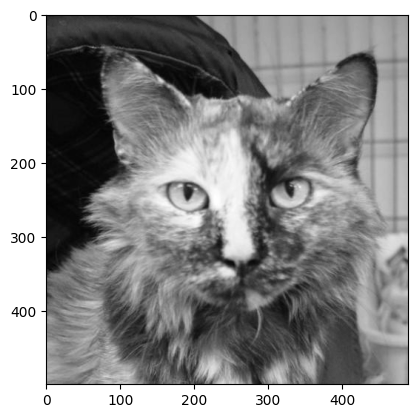

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
IMG_SIZE = 150
img_array = cv2.imread(os.path.join("PetImagesTesting/Cat","10.jpg") ,cv2.IMREAD_GRAYSCALE)  # convert to array
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
a = np.array(new_array).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
plt.imshow(img_array, cmap='gray')
a = a/255.0
a = np.array(a)

In [10]:
pred = loaded_model.predict(a)
pred

1/1 [==============================] - 0s 331ms/step


array([[0.909941]], dtype=float32)